In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
inspector = inspect(engine)
inspector.get_table_names()
measurements = inspector.get_columns('measurement')
for feature in measurements:
    print(feature['name'], feature['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [13]:
# dt.datetime.strptime(last_date[0], '%Y-%m-%d')-dt.timedelta(days=365)

NameError: name 'last_date' is not defined

In [14]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(10)
last_date = last_date[0]
measurements = session.query(Measurement).filter(Measurement.date >= dt.datetime.strptime(last_date[0], '%Y-%m-%d')-dt.timedelta(days=365))
df_prcp = pd.DataFrame(columns=['date', 'prcp'])
dates = []
prcps = []
for measurement in measurements:
    dates.append(measurement.date)
    prcps.append(measurement.prcp)
df_prcp['date']=dates
df_prcp['prcp']=prcps
df_prcp['date'] = pd.to_datetime(df_prcp['date'])

In [29]:
df_prcp.set_index('date', inplace=True)

In [30]:
df_prcp = df_prcp.dropna()

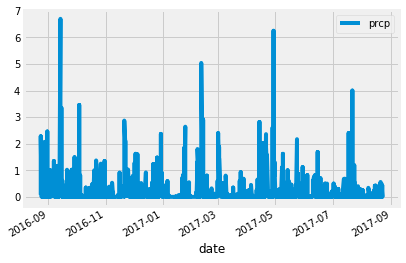

In [34]:
df_prcp.plot(use_index=True, y='prcp')

![precipitation](Images/precipitation.png)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(df_prcp.describe())

              prcp
count  2015.000000
mean      0.176462
std       0.460288
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
stations = inspector.get_columns('station')
for feature in stations:
    print(feature['name'], feature['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [178]:
# number of sessions, last id
session.query(func.count(Station.id)).first()

(9)

In [187]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
for i in session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()):
    print(i)
    
    

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [194]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
    
    

('USC00519281', 54.0, 85.0, 71.66378066378067)

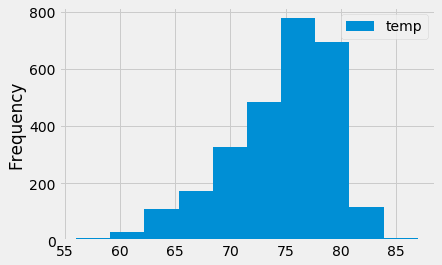

In [208]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_station = session.query(Measurement.station, func.count(Measurement.tobs)).filter(Measurement.date >= dt.datetime.strptime(last_date[0], '%Y-%m-%d')-dt.timedelta(days=365)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()[0]

df_temps = pd.DataFrame(columns=['date', 'temp'])
dates = []
temps = []

for row in session.query(Measurement).filter(Measurement.station==high_station):
    dates.append(row.date)
    temps.append(row.tobs)
df_temps['date']=dates
df_temps['temp']=temps
df_temps['date'] = pd.to_datetime(df_temps['date'])
df_temps.plot(y='temp', kind='hist')



In [13]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [14]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


Text(0,0.5,'Temp (F)')

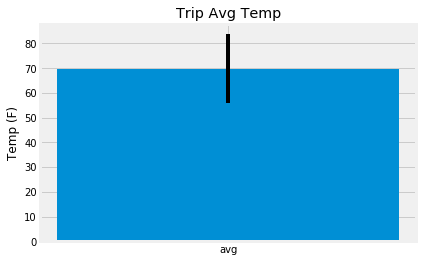

In [43]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(x='avg',height=calc_temps('2011-02-28', '2011-03-05')[0][1], width=10, yerr=calc_temps('2011-02-28', '2011-03-05')[0][2]-calc_temps('2011-02-28', '2011-03-05')[0][0])
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [53]:
dates = session.query(Measurement.date)
dates = list(set([x[0][5:] for x in dates]))

In [55]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [98]:
normals = pd.DataFrame(columns=['date', 'tmin', 'tavg', 'tmax'])
normals['date']=dates
ref = [(i, daily_normals(i)) for i in dates]
normals['tmin']= [x[1][0][0] for x in ref]
normals['tavg']= [x[1][0][1] for x in ref]
normals['tmax']= [x[1][0][2] for x in ref]
normals.sort_values('date', inplace=True)
# normals.set_index('date', inplace=True)

In [107]:
normals = normals.reset_index(drop=True)

AttributeError: 'NoneType' object has no attribute 'update'

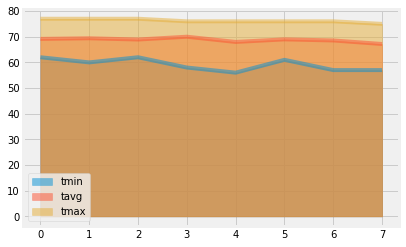

In [115]:
data = normals.loc[0:7]
data.plot(x='date', y=['tmin', 'tavg', 'tmax'], kind='area', stacked=False, xticks=data['date'])

In [25]:
from flask import jsonify
session.query(Station.station).first()


('USC00519397')